# TENSORFLOW EXAMPLES

In [1]:
%matplotlib inline
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shutil
from utils import *

/home/schmrlng/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Example 0: Accessing documentation

Shift-Enter to run the cells below:

In [ ]:
?tf.matmul

In [ ]:
?tf.reduce_mean

In [ ]:
?tf.get_variable

## Example 1: Creating a computation graph
We use tensorflow to define *computation graphs* which outline a sequence of computations but nothing is actually computed until you ask the computations to be run.

In [2]:
a = tf.constant(4)
b = tf.constant(7)
c = a + b
a, b, c

(<tf.Tensor 'Const:0' shape=() dtype=int32>,
 <tf.Tensor 'Const_1:0' shape=() dtype=int32>,
 <tf.Tensor 'add:0' shape=() dtype=int32>)

In [3]:
sess = tf.Session()

print sess.run(a)
print sess.run(b)
print sess.run(c)

sess.close()

4
7
11


Here is a more complicated example. Suppose you want to calculate the two functions:
$$ z = sin(ax+b) \qquad w = cos(ax+b) $$
where $x$ and $y$ are values from data and $a$ and $b$ are parameters (can be anything, perhaps variables to be optimized)

In [4]:
# Define your placeholders (variables where you _need_ to feed in numbers)
# The shape can be "None" since you do not need to specify how much data you will feed in. But you do need to specify the number of dimensions atleast.
x = tf.placeholder(dtype=tf.float32, shape=[None], name='x')
# Define a variable scope. The variables and operations defined here will be associated with the "example_1" scope name, which is useful for graph visualization.
with tf.variable_scope("example_1"):
    # Define your variables (these variables are parameters which may be updated at each iteration of an optimization process)
    a = tf.get_variable(name='a', dtype=tf.float32, shape=[1], initializer=tf.constant_initializer(np.array([1])))
    b = tf.get_variable(name='b', dtype=tf.float32, shape=[1], initializer=tf.constant_initializer(np.array([2])))
    # Compute quantities you are interested in
    z = tf.sin(a*x + b)
    w = tf.cos(a*x + b)

# After defining the necessary placeholders, variables and other quantities, we can initialize the computation graph and start a tensorflow session!
init_op = tf.global_variables_initializer()
with tf.Session() as sess:    # an alternative syntax for opening/automatically closing a Session compared to above
    sess.run(init_op)

    # Now, your graph is ready to go! Let us calculate z and w for many values of x and y!
    # First, generate x and y values
    N = 1000
    x_data = 10*np.random.rand(N)

    # Run the graph! The first argument tells us what nodes/operations you want to compute, and the second argument is a dictionary that assigns variables/placeholders a value.
    z_val, w_val = sess.run([z, w], {x:x_data})

To double check if we get the same answers, let's plot the values computed from Tensorflow and from calculating it directly using numpy.

Text(0.5,1,u'Red: computed using numpy, Blue: computed using tensorflow')

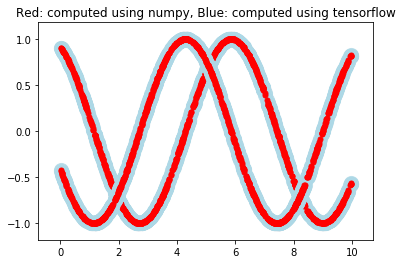

In [5]:
a = 1
b = 2
zz = np.sin(a*x_data+b)
ww = np.cos(a*x_data+b)
plt.scatter(x_data, z_val,s=200, alpha=0.7,c="lightblue")
plt.scatter(x_data, zz, s=25, c="red")
plt.scatter(x_data, w_val,s=200, alpha=0.7,c="lightblue")
plt.scatter(x_data, ww, s=25, c="red")
plt.title('Red: computed using numpy, Blue: computed using tensorflow')

Congratulations! You have just run data through a computation graph using Tensorflow! Feel free to experiment with other functions in the example.

## Example 2: Stepping through gradient descent
Linear regression is a linear approach for modeling a relationship between a scalar dependent variable y and independent variables X. In particular, it assumes the relationship $y^{(i)} = x^{(i)}W - b$ (this is actually affine but we can augment $x^{(i)}$ by concatenating it with a constant.)

Given a data set $x^{(1)}, x^{(2)},...,x^{(n)}$ and corresponding labels $y^{(i)}, y^{(2)},...,y^{(n)}$, we want to find $W$ and $b$ such that $y^{(i)} \approx x^{(i)}W - b$. The optimization problem for linear regression is as follows
$$ \min_{W,b} \frac{1}{n} \sum_{i=1}^n \| y^{(i)} - (x^{(i)}W-b) \|_2^2 $$

Here is an example on how to do a few steps of gradient step for a simple linear regression problem.
The lecture notes from CS 224d goes into this in more depth. Feel free to read the notes at https://cs224d.stanford.edu/lectures/CS224d-Lecture7.pdf.

In [6]:
# To refresh your computation graph, run the following command
tf.reset_default_graph()

In [7]:
# Parameters
w0 = -1    # initial guess for w0
b0 = 1     # initial guess for b0
lr = 0.05  # learning rate (step size)

Note that if the learning rate is too large, the gradient descent will become unstable. Thus in general, this should be small, but this means the update at each iteration is small.

In [8]:
# Generate data
x_data, y_data = generate_data('LS_linear', a=3, b=5, sigma=4)

Let's visualize what the data looks like and see what our initial guess is. It will not be a very good guess.

Text(0.5,1,u'Initial guess for w and b')

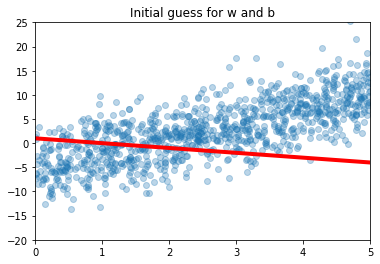

In [9]:
# Initial guess for w and b
x0 = np.array([0, 5])
plt.scatter(x_data, y_data, alpha=0.3, label="Training data")
plt.plot(x0, x0*w0 + b0, c='red', linewidth=4, label="Initial guess for a linear fit")
plt.axis([0, 5, -20, 25])
plt.title('Initial guess for w and b')

## Defining your TensorFlow graph

In [10]:
# Define placeholders where your data will be fed in
x_dim = 1
y_dim = 1
x = tf.placeholder(dtype=tf.float32, shape=[None, x_dim], name='x')
y = tf.placeholder(dtype=tf.float32, shape=[None, y_dim], name='y')

# Define the nodes of your graph
with tf.variable_scope("example_2"):
    W = tf.get_variable(name='weights', dtype=tf.float32, shape=[x_dim,y_dim], initializer=tf.constant_initializer(np.array([w0])))
    b = tf.get_variable(name='bias', dtype=tf.float32, shape=[y_dim], initializer=tf.constant_initializer(np.array([b0])))
    # Assuming a "y = wx - b" model
    y_pred = tf.matmul(x, W) - b
    loss = tf.reduce_mean((y - y_pred)**2)

# Define a type of optimzer    
opt = tf.train.GradientDescentOptimizer(lr)
# what do you want your optimizer to do?
opt_operation = opt.minimize(loss)

# Define your graph and start a session
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)



# Run the computations defined by your graph 
# the first argument in sess.run is a list of nodes you want to evaluate and the 
# second entry is a dictionary that feeds information into other nodes
# we're doing "full" gradient descent here, not stochastic gradient descent as each
# batch is our entire dataset (x_data, y_data)
_, loss_val, w_val, b_val = sess.run([opt_operation, loss, W, b], feed_dict={x:x_data, y:y_data})

print "Starting loss: ", loss_val, ", W = ", w_val, ", b = ", b_val

Starting loss:  86.71845 W =  [[-1.]] b =  [1.]


## Iteration 1 of gradient descent

Loss:  22.874762 W =  [[1.3646946]] b =  [0.394256]


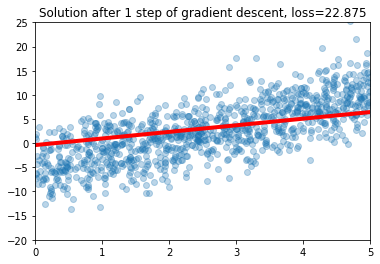

In [11]:
# Run the graph operations again to take a gradient descent step
_, loss_val, w_val, b_val = sess.run([opt_operation, loss, W, b], feed_dict={x:x_data, y:y_data})
# Plot what your estimate is
plt.scatter(x_data, y_data, alpha=0.3)
plt.plot(np.array([0, 5]), x0*w_val[0] - b_val[0], c='red', linewidth=4)
plt.axis([0, 5, -20, 25])
plt.title('Solution after 1 step of gradient descent, loss=%.3f'%loss_val)
print "Loss: ", loss_val, ", W = ", w_val, ", b = ", b_val

## Iteration 2 of gradient descent
See if there are any changes to your solution. (It will be a small update since the learning rate is small.)

Loss:  22.325907 W =  [[1.5590794]] b =  [0.45037997]


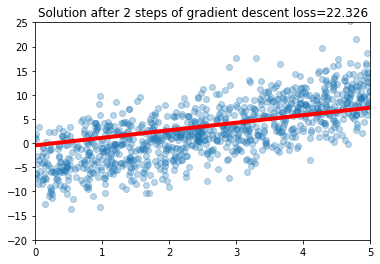

In [12]:
# Run your graph again to take another gradient descent step
_, loss_val, w_val, b_val = sess.run([opt_operation, loss, W, b], feed_dict={x:x_data, y:y_data})
# Plot what your estimate is
plt.scatter(x_data, y_data, alpha=0.3)
plt.plot(np.array([0, 5]), x0*w_val[0] - b_val[0], c='red', linewidth=4)
plt.axis([0, 5, -20, 25])
plt.title('Solution after 2 steps of gradient descent loss=%.3f'%loss_val)
print "Loss: ", loss_val, ", W = ", w_val, ", b = ", b_val

Congratulations! You have just computed a few gradient descents of a linear regression problem using Tensorflow. Feel free to play around with this more. In particular, keep on running the cell above and you should see the red line (slowly) starting to align with the axis of the noisy data.

## Example 3: Linear Regression using TensorFlow Estimator framework
In example 2, we solved the linear regressiong using the tf.InteractionSession() functionality. This environment is very flexible and useful for prototyping. However, when your tensorflow projects become larger and more complicated, it will be more useful to work in a more structured environment where a lot of "house-keeping" is done automatically (e.g., batching for stochastic gradient descent, using evaluation set). In this example, we will solve the same linear regression problem, but we will use the TensorFlow Estimator framework (tf.estimator.Estimator). For more details, visit the TensorFlow documentation: https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator

In [ ]:
# get information about tf.estimator.Estimator
?tf.estimator.Estimator

In [13]:
# Generating training, evaluation, test and true data set.
x_train, y_train = generate_data('LS_linear', a=3, b=5, sigma=4)
x_eval, y_eval = generate_data('LS_linear', a=3, b=5, sigma=4, N=1000)
x_pred, _ = generate_data('LS_linear', a=3, b=5, sigma=4, N=500)
x_true, y_true = generate_data('LS_linear', a=3, b=5, sigma=0, N=500)

In [14]:
# Settings for the estimator
# location to save model info while training
model_dir = 'training_checkpoints'
# configuration stuff (you do not need to change this)
rc = tf.estimator.RunConfig().replace(model_dir=model_dir,
                                      tf_random_seed=None,
                                      save_summary_steps=100,
                                      save_checkpoints_steps=1000,
                                      keep_checkpoint_max=1000,
                                      log_step_count_steps=1000)

# hyperparameters: batch sizes, learning rate, dimension of label (y)
hps = tf.contrib.training.HParams(
    train_batch_size = 100,
    eval_batch_size = 10,
    lr = 0.01,
    y_dim = 1
    )


In [15]:
# Defining necessary functions for the estimator 
# input data functions for train, evalulation and prediction
# note that x and y are fed in as dictionaries
train_input_function = tf.estimator.inputs.numpy_input_fn(x={"x":x_train},
                                                          y={"y":y_train},
                                                          batch_size=hps.train_batch_size,
                                                          num_epochs=None,
                                                          shuffle=True)
eval_input_function = tf.estimator.inputs.numpy_input_fn(x={"x":x_eval},
                                                         y={"y":y_eval},
                                                         batch_size=hps.eval_batch_size,
                                                         num_epochs=1,
                                                         shuffle=False)
def predict_input_function(x_dict):
    return tf.estimator.inputs.numpy_input_fn(x=x_dict,
                                              num_epochs=1,
                                              shuffle=False)

# The model function, the "main" function that defines the graph 
def model_fn(features, labels, mode, params):
    # defining variables, possibly be overriden later
    predictions = None
    loss = None
    train_op = None
    eval_metric_ops = None 
    export_outputs = None
    x = tf.to_float(features["x"])
    # if this is in train or evaluation mode, do this:
    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        y = tf.to_float(labels["y"])
        # define variable scope
        with tf.variable_scope("linear_regression"):
            W = tf.get_variable("weights", dtype=tf.float32, shape=(x.shape[-1],1))
            b = tf.get_variable("bias", dtype=tf.float32, shape=(1,))
            y_est = tf.matmul(x, W) - b
            # calculate loss for least squares regression
            loss = tf.reduce_mean(tf.norm(y - y_est, axis=-1)**2)
            eval_metric_ops = {"eval_loss": tf.metrics.mean(loss)}
            # if in train mode, define the optimizer and training operation 
            if mode == tf.estimator.ModeKeys.TRAIN:
                opt = tf.train.AdamOptimizer(learning_rate=params.lr)
                train_op = opt.minimize(loss, tf.train.get_global_step())
    # if this is in predict mode, do this:            
    elif mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {}
        # using the linear_regression variable scope, we want to compute y_est given the x inputs
        with tf.variable_scope("linear_regression"):
            W = tf.get_variable("weights", dtype=tf.float32, shape=(x.shape[-1],1))
            b = tf.get_variable("bias", dtype=tf.float32, shape=(1,))
            y_est = tf.matmul(x, W) - b
            predictions["y_est"] = y_est
    # the output must be in of this form
    return tf.estimator.EstimatorSpec(mode, 
                                      predictions=predictions, 
                                      loss=loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

In [16]:
# Define the estimator object
estimator_model = tf.estimator.Estimator(model_fn, 
                                         params=hps, 
                                         config=rc,
                                         model_dir=model_dir,
                                         )

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 1000, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f05e069a390>, '_save_checkpoints_steps': 1000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 1000, '_model_dir': 'training_checkpoints', '_save_summary_steps': 100}


In [17]:
# Define the sepcifications for training and evaluation
train_spec = tf.estimator.TrainSpec(input_fn=train_input_function, max_steps=2000)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_function, steps=100, start_delay_secs=0)

In [18]:
# Clear any cached results from previous training runs and start training and evaluating the model
shutil.rmtree(model_dir, ignore_errors=True)
tf.estimator.train_and_evaluate(estimator_model, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into training_checkpoints/model.ckpt.
INFO:tensorflow:loss = 75.570045, step = 1
INFO:tensorflow:loss = 32.672184, step = 101 (0.156 sec)
INFO:tensorflow:loss = 27.092781, step = 201 (0.144 sec)
INFO:tensorflow:loss = 21.334751, step = 301 (0.139 sec)
INFO:tensorflow:loss = 17.678263, step = 401 (0.141 sec)
INFO:tensorflow:loss = 31.123499, step = 501 (0.142 sec)
INFO:tensorflow:loss = 21.165625, step = 601 (0.144 sec)
INFO:tensorflow:loss = 19.3946, step = 701 (0.144 sec)
INFO:tensorflow:loss = 17.834948, step = 801 (0.148 sec)
INFO:tensorflow:loss = 11.566765, step = 901 (0.159 sec)
INFO:tensorflow:Saving checkpoints for 1001 into training_checkpoints/model.ckpt.
INFO:tensorflow:global_step/

INFO:tensorflow:Restoring parameters from training_checkpoints/model.ckpt-2000


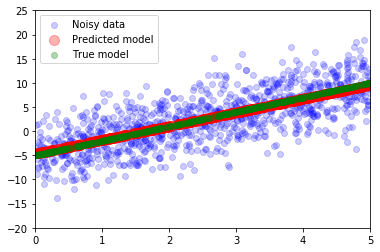

In [19]:
# Make predictions given new x data and compare with the noisy (training) data and the true linear function used to generate the data in the first place
y_predict = estimator_model.predict(predict_input_function({"x":x_pred}), predict_keys = "y_est")
y_pred = [y["y_est"] for y in y_predict]
plt.scatter(x_train, y_train, c="blue", alpha=0.2, label="Noisy data")
plt.scatter(x_pred, y_pred, c="red", alpha=0.3, s=100, label="Predicted model")
plt.scatter(x_true, y_true, c="green", alpha=0.3, label="True model")
plt.axis([0, 5, -20, 25])
plt.legend(loc=2)

# Optional: Try fit this data set using least squares
You can try experiment with different features, such as $x^2$, $e^{x}$, etc.

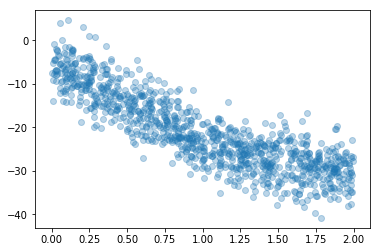

In [20]:
# Generate data
x_data, y_data = generate_data('LS_quad', a=6, b=-25, d=2, sigma=4)
# Initial guess for w and b
x0 = np.array([0, 5])
plt.scatter(x_data, y_data, alpha=0.3, label="Training data")